
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio A/B Testing Parametrico

⚠️ Recuerda en caso de que los resultados no sean suficientes una imagen vale mas que mil palabras 


#### Ejercicio 1:  Linea de montaje 

En una fabrica de componenetes textil se quiere comparar el tiempo de fabricacion de un determinado producto mediante tres métodos diferentes. Cada uno de los metodos se realizan en maquinas distintas. Se seleccionan aleatoriamente productos elaborados con cada uno de los métodos y se observa el tiempo de fabricación.  Si los tiempos de fabricacion son negativos significara que las maquinas estuvieron paradas esos minutos. 



1. ¿Se verifican los supuestos del modelo de análisis de la varianza?

2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?

3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
!pip install statsmodels
import pandas as pd
import numpy as np

# Calcular el tamaño muestral
# -----------------------------------------------------------------------
from statsmodels.stats.power import NormalIndPower
import statsmodels.stats.api as sms


# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


# Importamos las funciones del archivo de soporte
# ------------------------------------------------------------------------------
import sys
sys.path.append("../")
from src import soporte_m6 as sa


# Otros recursos
# ------------------------------------------------------------------------------
import math

# Configuración de las gráficas
# ------------------------------------------------------------------------------
# establece el estilo del fondo de las gráficas como "whitegrid". Las gráficas tendrán un fondo blanco con líneas de cuadrícula horizontales y verticales.
sns.set_style("dark")

# cambiará el esquema de colores predeterminado de Seaborn a uno más oscuro, adecuado para gráficas con fondos claros. 
sns.set_theme(style="dark")

# establece el estilo en seaborn-v0_8-darkgrid. 
plt.style.use('dark_background')

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Cargamos datos:
df_linea_montaje = pd.read_csv("../../Labs/Datos/linea_montaje.csv")
df_linea_montaje.head()

minutos metodo
0  4.166484      A
1  4.887466      A
2  0.727608      A
3  8.280542      A
4  1.413129      A

In [3]:
#Los supuestos del modelo de análisis de la varianza son: independencia, homocedasticidad, y normalidad. Comenzamos echando un ojo a los datos:
sa.exploracion_dataframe(df_linea_montaje,"metodo")

#POdemos Observar que C tiene la mayor media y desviación típica, y B tiene un mínimo negativo

El número de datos es 150 y el de columnas es 2

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


Empty DataFrame
Columns: [%_nulos]
Index: []


 ..................... 

Los tipos de las columnas son:


tipo_dato
minutos   float64
metodo     object


 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna METODO tiene las siguientes valore únicos:


count
metodo       
A          50
B          50
C          50


 ..................... 

Los principales estadísticos de las columnas categóricas para el A son: 


count unique top freq
metodo    50      1   A   50


 ..................... 

Los principales estadísticos de las columnas numéricas para el A son: 


count      mean       std       min       25%       50%       75%  \
minutos   50.0  4.720512  2.102454  0.130465  3.312806  4.690071  6.005251   

              max  
minutos  9.584416


 ..................... 

Los principales estadísticos de las columnas categóricas para el B son: 


count unique top freq
metodo    50      1   B   50


 ..................... 

Los principales estadísticos de las columnas numéricas para el B son: 


count      mean       std       min       25%       50%       75%  \
minutos   50.0  4.364523  2.085242 -0.818899  3.597334  4.506685  5.825817   

              max  
minutos  7.668974


 ..................... 

Los principales estadísticos de las columnas categóricas para el C son: 


count unique top freq
metodo    50      1   C   50


 ..................... 

Los principales estadísticos de las columnas numéricas para el C son: 


count      mean       std       min       25%       50%       75%  \
minutos   50.0  5.600274  2.329937  1.334696  4.071824  5.064969  6.976655   

               max  
minutos  12.059491

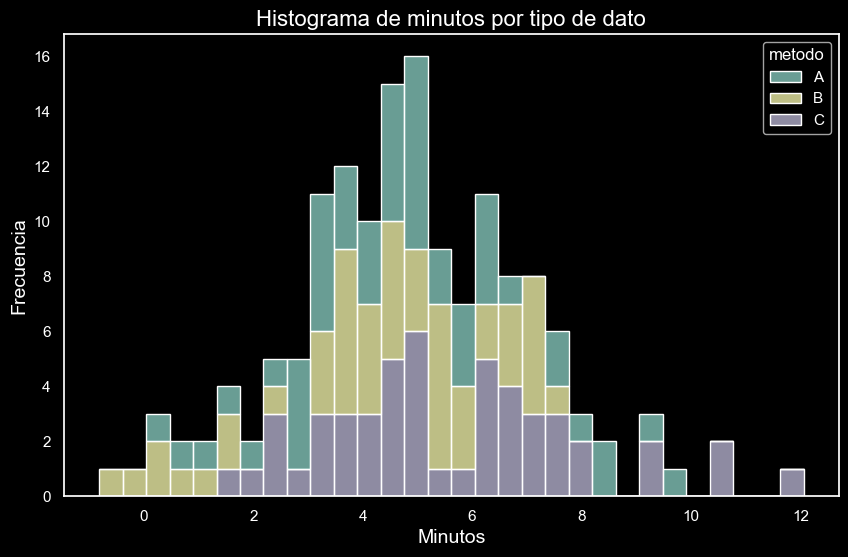

In [4]:
# Visualizamos:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_linea_montaje, x='minutos', hue='metodo', multiple='stack', kde=False, bins = 30)

plt.title('Histograma de minutos por tipo de dato', fontsize=16)
plt.xlabel('Minutos', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

plt.show()

# En principio ninguno parece normal. Hacemos la comprobación

In [5]:
#Eliminamos los datos negativos y comprobamos
df_linea_montaje.drop(df_linea_montaje[df_linea_montaje["minutos"] < 0].index, inplace=True)
df_linea_montaje[df_linea_montaje["minutos"] < 0]

Empty DataFrame
Columns: [minutos, metodo]
Index: []

In [6]:
#Damos por hecho que los datos son independientes. Como hay más de 30 datos usaremos K-S para testear la normalidad de cada conjunto.
from scipy.stats import kstest
# Iterar sobre los grupos (por ejemplo, por 'tipo_dato')
for tipo in df_linea_montaje['metodo'].unique():
    # Filtrar el DataFrame para cada grupo
    grupo = df_linea_montaje[df_linea_montaje['metodo'] == tipo]
    
    # Calcular la media y la desviación estándar del grupo
    media = grupo['minutos'].mean()
    desviacion = grupo['minutos'].std()
    
    # Aplicar el test de Kolmogorov-Smirnov para la distribución normal
    stat, p_value = kstest(grupo['minutos'], 'norm', args=(media, desviacion))
    
    # Mostrar los resultados para cada grupo
    print(f'Grupo: {tipo}')
    print(f'Estadístico KS: {stat}')
    print(f'Valor p: {p_value}')
    
    # Interpretación del valor p
    if p_value > 0.05:
        print("No se puede rechazar la hipótesis nula: los datos siguen una distribución normal")
    else:
        print("Se rechaza la hipótesis nula: los datos no siguen una distribución normal")
    
    print('---')

Grupo: A
Estadístico KS: 0.08510025236028507
Valor p: 0.831915919566997
No se puede rechazar la hipótesis nula: los datos siguen una distribución normal
---
Grupo: B
Estadístico KS: 0.08919864422432602
Valor p: 0.8071977044427
No se puede rechazar la hipótesis nula: los datos siguen una distribución normal
---
Grupo: C
Estadístico KS: 0.10224330731103809
Valor p: 0.6354526500316278
No se puede rechazar la hipótesis nula: los datos siguen una distribución normal
---


In [7]:
from scipy.stats import levene
# Inicializamos un diccionario para almacenar los resultados
resultados_levene = {}

# Iterar sobre los grupos (por ejemplo, por 'tipo_dato')
for tipo in df_linea_montaje['metodo'].unique():
    # Filtrar el DataFrame para cada grupo
    grupo = df_linea_montaje[df_linea_montaje['metodo'] == tipo]
    
    # Almacenamos los datos de cada grupo en una lista para aplicar el test de Levene
    resultados_levene[tipo] = grupo['minutos'].values

# Aplicamos el test de Levene para comparar las varianzas entre los grupos
stat, p_value = levene(*resultados_levene.values())

# Mostrar los resultados
print(f'Estadístico Levene: {stat}')
print(f'Valor p: {p_value}')

# Interpretación del valor p
if p_value > 0.05:
    print("No se puede rechazar la hipótesis nula: las varianzas son homogéneas entre los grupos")
else:
    print("Se rechaza la hipótesis nula: las varianzas no son homogéneas entre los grupos")

Estadístico Levene: 1.0626920726615094
Valor p: 0.34819974732699716
No se puede rechazar la hipótesis nula: las varianzas son homogéneas entre los grupos


In [8]:
#Observamos que los datos son normales y homocedásticos, vamos a usar ANOVA para ver si hay diferencias 
from scipy.stats import f_oneway
# Filtramos los datos por cada grupo
grupos = [df_linea_montaje[df_linea_montaje['metodo'] == tipo]['minutos'] for tipo in df_linea_montaje['metodo'].unique()]

# Aplicamos el test de ANOVA de una vía
stat, p_value = f_oneway(*grupos)

# Mostrar los resultados
print(f'Estadístico ANOVA: {stat}')
print(f'Valor p: {p_value}')

# Interpretación del valor p
if p_value > 0.05:
    print("No se puede rechazar la hipótesis nula: no hay diferencias significativas entre los grupos")
else:
    print("Se rechaza la hipótesis nula: hay diferencias significativas entre los grupos")

Estadístico ANOVA: 3.451228961333596
Valor p: 0.034334606507256296
Se rechaza la hipótesis nula: hay diferencias significativas entre los grupos


In [9]:
# El método B tiene menor tiempo medio, por eso es más aconsejable

#### Ejercicio 2: Densidad de Fluidos 


La convección es un mecanismo fundamental de transferencia de calor en fluidos, que ocurre debido a las variaciones en la densidad provocadas por diferencias de temperatura. Este fenómeno se manifiesta cuando las porciones del fluido que se calientan, al volverse menos densas, ascienden hacia regiones de menor temperatura, mientras que las porciones más frías, al ser más densas, descienden hacia las zonas donde la temperatura es más alta. Este movimiento continuo da lugar a las llamadas corrientes de convección, las cuales desempeñan un papel crucial en la distribución homogénea de la temperatura dentro del fluido, promoviendo un equilibrio térmico.

En este contexto, se ha diseñado y ejecutado un experimento con el propósito de investigar cómo se ve afectada la densidad de un fluido cuando se incrementa la temperatura en una región específica del sistema; por tanto se asegura la independencia y aleatoriedad del mismo. El objetivo del experimento es comprender en detalle las modificaciones en la densidad que resultan de este aumento térmico y cómo estas afectan el comportamiento global del fluido.


1. Analiza las suposiciones del modelo: ¿Se cumplen las condiciones de homocedasticidad, independencia y normalidad?
2. ¿Tiene la temperatura un impacto notable en la densidad del fluido?
3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

In [10]:
#Importamos datos
df_densidad = pd.read_csv("../../Labs/Datos/densidad_fluidos.csv")

In [11]:
df_densidad["temperatura"].unique()

array([100, 125, 150, 175])

In [12]:
sa.exploracion_dataframe(df_densidad,"temperatura")

El número de datos es 400 y el de columnas es 2

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


Empty DataFrame
Columns: [%_nulos]
Index: []


 ..................... 

Los tipos de las columnas son:


tipo_dato
temperatura     int64
densidad      float64


 ..................... 

Los valores que tenemos para las columnas categóricas son: 

 ..................... 

Los principales estadísticos de las columnas categóricas para 100 son: 


ValueError: No objects to concatenate